# Import all libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # only for style
from sklearn.feature_extraction.text import CountVectorizer
from datetime import timedelta
from collections import Counter
pd.set_option('display.max_columns', None)

# Read the csvs and merge if needed for later Knowledge graph building

In [2]:
df = pd.read_csv('health_reports_data.csv', parse_dates=['timestamp', 'date'])

# Remove unnecessary columns which only indicate id (not beneficial for Knowledge graph)

In [3]:
df['actual_disease'].value_counts()

actual_disease
gastroenteritis    2670
malaria            1843
covid19            1571
food_poisoning     1153
influenza          1059
meningitis          880
pneumonia           824
Name: count, dtype: int64

In [4]:
df.drop(columns=['intervention_intervention_id'], inplace=True)

In [4]:
df

,timestamp,age,age_group,gender,region,latitude,longitude,symptoms_text,actual_disease,severity,is_outbreak_related,contact_tracing_needed,hospitalization_required,date,month,day_of_week,hour,intervention_type,intervention_region,intervention_target_disease,intervention_start_date,intervention_duration_days,intervention_effectiveness_score,intervention_cost,intervention_population_affected,intervention_compliance_rate
0,2022-05-18,25,young_adult,male,coastal_region,40.985640,-74.072070,"Patient presents with severe headache, sweats,...",malaria,moderate,False,False,False,2022-05-18,5,2,7,public_awareness,coastal_region,malaria,2023-09-26,49,0.585119,964587,16790,0.722803
1,2023-11-02,76,elderly,male,suburban_area,40.364651,-73.615272,"Patient presents with queasiness, being sick a...",gastroenteritis,mild,True,False,False,2023-11-02,11,3,11,quarantine,suburban_area,gastroenteritis,2020-08-17,74,0.381869,681812,7606,0.375233
2,2023-07-09,22,young_adult,male,rural_district,41.183955,-73.645448,"Symptoms include diarrhea, feeling hot and bei...",gastroenteritis,moderate,False,False,False,2023-07-09,7,6,19,travel_restriction,rural_district,gastroenteritis,2023-07-24,26,0.498180,210187,6005,0.408917
3,2024-06-22,13,teenager,female,coastal_region,40.853977,-74.324275,"Clinical presentation: queasiness, migraine an...",malaria,moderate,True,False,False,2024-06-22,6,5,14,social_distancing,coastal_region,malaria,2025-09-27,89,0.372933,492199,14185,0.795268
4,2022-03-15,5,child,other,rural_district,40.478699,-74.287182,"Patient presents with high temperature, neck s...",meningitis,severe,False,False,True,2022-03-15,3,1,10,contact_tracing,rural_district,meningitis,2023-06-19,35,0.171547,80318,34804,0.671716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2024-06-22,13,teenager,female,coastal_region,40.853977,-74.324275,"Clinical presentation: queasiness, migraine an...",malaria,moderate,True,False,False,2024-06-22,6,5,14,public_awareness,coastal_region,malaria,2023-09-26,49,0.585119,964587,16790,0.722803
9996,2023-12-06,91,elderly,other,suburban_area,40.290548,-73.976622,"Clinical presentation: fever, chills, cough wi...",pneumonia,severe,False,False,True,2023-12-06,12,2,10,mask_mandate,suburban_area,pneumonia,2021-10-02,8,0.896289,189528,89021,0.803295
9997,2025-05-26,17,teenager,male,rural_district,41.045955,-74.327409,Patient presents with fever and body aches,malaria,mild,True,False,False,2025-05-26,5,0,21,school_closure,rural_district,malaria,2022-09-24,72,0.859564,935370,94336,0.332536
9998,2023-07-11,71,senior,male,urban_center,41.147313,-74.131450,"Clinical presentation: severe headache, confus...",meningitis,severe,False,False,True,2023-07-11,7,1,12,mask_mandate,urban_center,meningitis,2023-11-08,77,0.346216,380537,17772,0.490434


In [8]:
df.to_excel('health_reports_data.xlsx', index=True)

In [5]:
df['is_outbreak_related'].value_counts()

is_outbreak_related
False    6000
True     4000
Name: count, dtype: int64

# Data Analysis

In [7]:
df.columns

Index(['timestamp', 'age', 'age_group', 'gender', 'region', 'latitude',
       'longitude', 'symptoms_text', 'actual_disease', 'severity',
       'is_outbreak_related', 'contact_tracing_needed',
       'hospitalization_required', 'date', 'month', 'day_of_week', 'hour',
       'intervention_type', 'intervention_region',
       'intervention_target_disease', 'intervention_start_date',
       'intervention_duration_days', 'intervention_effectiveness_score',
       'intervention_cost', 'intervention_population_affected',
       'intervention_compliance_rate'],
      dtype='object')

In [8]:
plt.rcParams['figure.figsize'] = (10, 6)

## 2. Demographic Breakdown: Age-Group vs. Severity

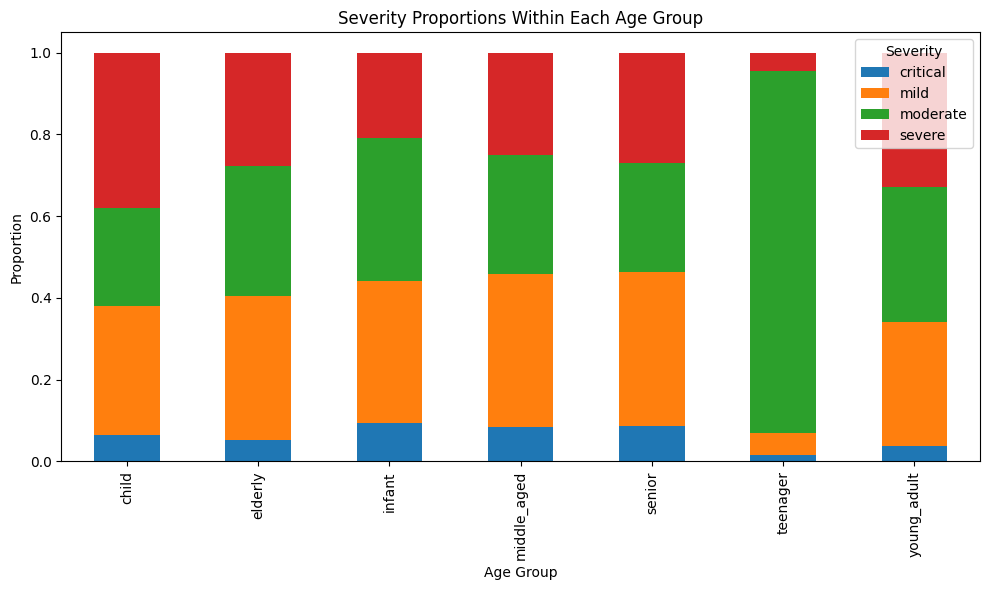

In [10]:
age_sev = pd.crosstab(df['age_group'], df['severity'], normalize='index')
age_sev.plot(kind='bar', stacked=True)
plt.title('Severity Proportions Within Each Age Group')
plt.xlabel('Age Group')
plt.ylabel('Proportion')
plt.legend(title='Severity')
plt.tight_layout()
plt.show()

## 3. Geographic Distribution: Case Density Map (Scatter)

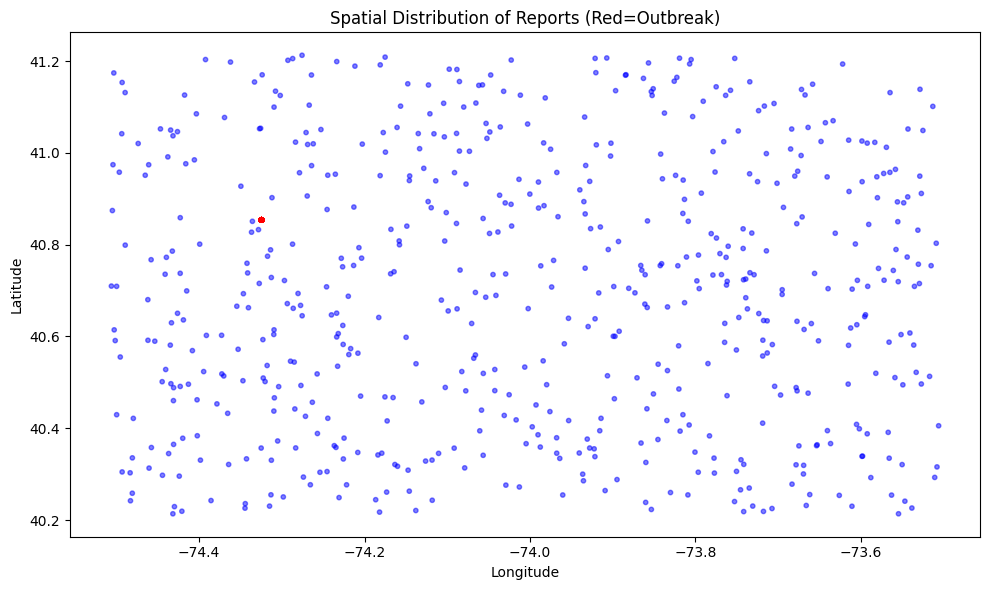

In [11]:
plt.scatter(df['longitude'], df['latitude'],
            c=df['is_outbreak_related'].map({True: 'red', False: 'blue'}),
            alpha=0.5, s=10)
plt.title('Spatial Distribution of Reports (Red=Outbreak)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()

# Generate health reports

In [12]:
all_symptoms = df['symptoms_text'].dropna().str.lower().str.split(',|\band\b|\bwith\b|\binclude\b').explode().str.strip()

# Count frequencies
symptom_counts = Counter(all_symptoms)
print(pd.DataFrame(symptom_counts.most_common(20), columns=['Symptom', 'Count']))

                                  Symptom  Count
0       clinical presentation: queasiness    409
1                     migraine and sweats    401
2                                  chills     36
3                    sensitivity to light     31
4                         severe headache     30
5                                   fever     23
6                               confusion     23
7                          neck stiffness     22
8                             feeling hot     22
9                              queasiness     21
10                      cough with phlegm     21
11                       high temperature     20
12           patient presents with chills     17
13                             exhaustion     15
14           clinical presentation: fever     15
15                    shortness of breath     14
16                         abdominal pain     13
17                   elevated temperature     13
18                                fatigue     12
19  patient presents

In [14]:
high_risk = df.groupby(['region', 'actual_disease']).size().reset_index(name='case_count')

# Top risky regions per disease
top_risky_regions = high_risk.sort_values(['actual_disease', 'case_count'], ascending=[True, False])
print(top_risky_regions.groupby('actual_disease').head(3))  # top 3 per disease

             region   actual_disease  case_count
21    suburban_area          covid19          16
14   rural_district          covid19          15
0    coastal_region          covid19          13
8   industrial_zone   food_poisoning          25
1    coastal_region   food_poisoning          18
15   rural_district   food_poisoning          17
30     urban_center  gastroenteritis          25
23    suburban_area  gastroenteritis          24
2    coastal_region  gastroenteritis          23
31     urban_center        influenza          23
24    suburban_area        influenza          22
10  industrial_zone        influenza          20
4    coastal_region          malaria         417
25    suburban_area          malaria          23
11  industrial_zone          malaria          13
33     urban_center       meningitis          19
26    suburban_area       meningitis          18
5    coastal_region       meningitis          15
13  industrial_zone        pneumonia          22
27    suburban_area 

In [15]:
def generate_health_summary(df):
    report = []
    top_symptoms = Counter(df['symptoms_text'].dropna().str.lower().str.split(',|\band\b|\bwith\b|\binclude\b').explode().str.strip()).most_common(5)
    report.append("Top reported symptoms:")
    report.extend([f"- {symptom} ({count} cases)" for symptom, count in top_symptoms])
    
    most_common_diseases = df['actual_disease'].value_counts().head(3)
    report.append("\nTop 3 diseases by frequency:")
    for disease, count in most_common_diseases.items():
        report.append(f"- {disease}: {count} cases")
    
    high_risk_regions = df.groupby('region').size().sort_values(ascending=False).head(3)
    report.append("\nTop 3 high-risk regions:")
    for region, count in high_risk_regions.items():
        report.append(f"- {region}: {count} reports")
    
    return "\n".join(report)

print(generate_health_summary(df))


Top reported symptoms:
- clinical presentation: queasiness (409 cases)
- migraine and sweats (401 cases)
- chills (36 cases)
- sensitivity to light (31 cases)
- severe headache (30 cases)

Top 3 diseases by frequency:
- malaria: 473 cases
- gastroenteritis: 105 cases
- influenza: 99 cases

Top 3 high-risk regions:
- coastal_region: 515 reports
- suburban_area: 135 reports
- urban_center: 124 reports


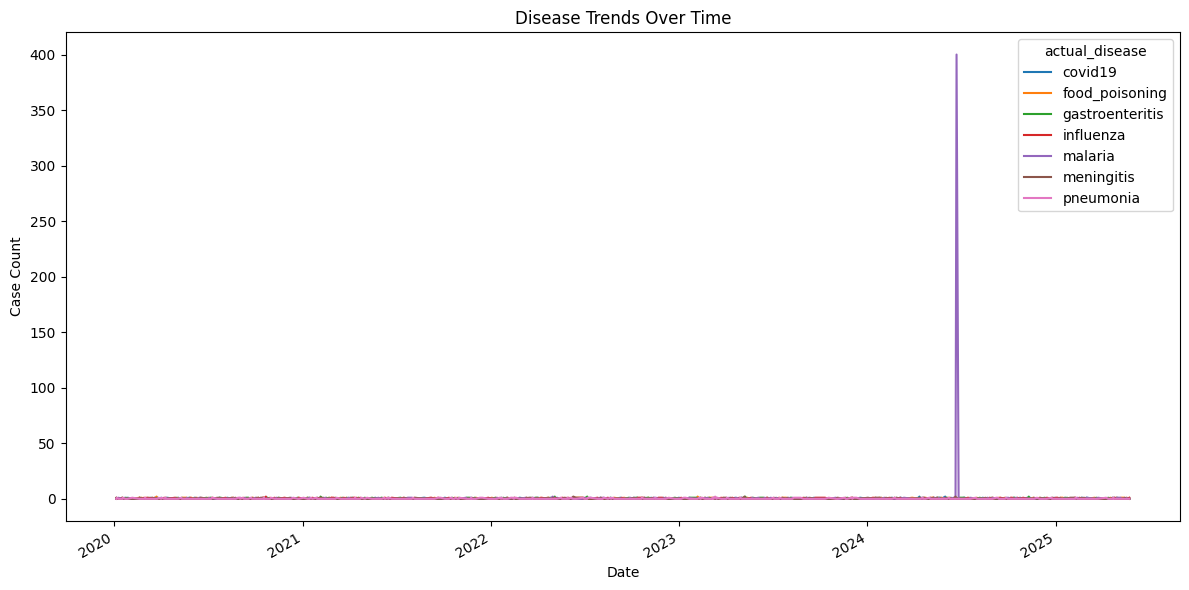

In [16]:
df_time = df.groupby(['date', 'actual_disease']).size().unstack(fill_value=0)
df_time.plot(figsize=(12, 6), title='Disease Trends Over Time')
plt.ylabel('Case Count')
plt.xlabel('Date')
plt.tight_layout()
plt.show()